# For existing experiment data, forward propagate the next few projections 

In [1]:
import mumott
print(mumott.__version__)

2.1


In [2]:
from mumott.data_handling import DataContainer
from mumott import Geometry
import copy
from mumott.methods.projectors import SAXSProjectorCUDA, SAXSProjector
import numpy as np
import matplotlib.pyplot as plt
import torch
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget

In [ ]:
#load data
# dc = DataContainer('/myhome/data/smartt/shared/frogbone/dataset_qbin_0009.h5')
dc = DataContainer('/das/home/barbaf_l/p20639/Mads/frog/frogbone/dataset_qbin_0009.h5', nonfinite_replacement_value=0.0)

INFO:Rotation matrices were loaded from the input file.


/das/work/units/pem/p20639/envs/p20639/lib/python3.9/site-packages/mumott/data_handling/data_container.py:227: DeprecationWarning: Entry name rotations is deprecated. Use inner_angle instead.
  _deprecated_key_warning('rotations')
/das/work/units/pem/p20639/envs/p20639/lib/python3.9/site-packages/mumott/data_handling/data_container.py:236: DeprecationWarning: Entry name tilts is deprecated. Use outer_angle instead.
  _deprecated_key_warning('tilts')
/das/work/units/pem/p20639/envs/p20639/lib/python3.9/site-packages/mumott/data_handling/data_container.py:246: DeprecationWarning: Entry name rot_mat is deprecated. Use rotation_matrix instead.
  _deprecated_key_warning('rot_mat')
/das/work/units/pem/p20639/envs/p20639/lib/python3.9/site-packages/mumott/data_handling/data_container.py:268: DeprecationWarning: Entry name offset_j is deprecated. Use j_offset instead.
  _deprecated_key_warning('offset_j')
/das/work/units/pem/p20639/envs/p20639/lib/python3.9/site-packages/mumott/data_handling/d

INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.


In [4]:
#save copy of origial geometry
projections = dc.projections
dc_copy = copy.deepcopy(dc)
geometry_real = dc_copy.geometry
rotations_real = dc_copy.geometry.rotations
joff = dc_copy.geometry.j_offsets
koff = dc_copy.geometry.k_offsets

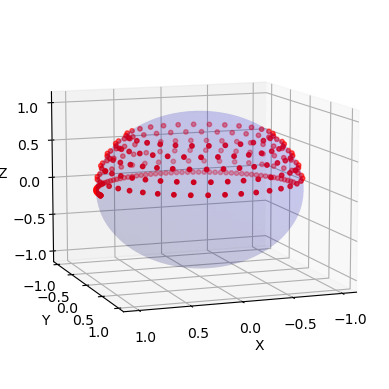

In [5]:
#plot original projections
rotation_angles_rad = dc.geometry.inner_angles[:]
tilt_angles_rad = list(np.pi/2-np.array(dc.geometry.outer_angles))[:]

r = 1
x = r * np.sin(tilt_angles_rad) * np.cos(rotation_angles_rad)
y = r * np.sin(tilt_angles_rad) * np.sin(rotation_angles_rad)
z = r * np.cos(tilt_angles_rad)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
X = r * np.outer(np.cos(u), np.sin(v))
Y = r * np.outer(np.sin(u), np.sin(v))
Z = r * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(X, Y, Z, color='b', alpha=0.1)  
ax.scatter(x, y, z, color='r', s=10)  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=10, azim=70)
plt.show()

In [6]:
# indices are calculated based on max-min sampling strategy, then m decides how many projections for reconstruction, n decides how many next projections for prediction
m = 60
n = 5
indices_first_120 = [20,   0,  51,  71,  92, 112, 172, 192,  41,  61,  81, 100,  13,
        33, 149, 129, 221, 241, 118, 210, 230,   9, 203,  29, 139, 183,
       176, 196, 162,  85, 105, 167, 187, 158,   4,  24, 145,  96, 135,
       214, 234,  46,  66, 245, 225, 122,  56, 154,  76,  16,  37, 125,
       132, 142, 179, 199,  89, 108, 115, 217, 237,   6,   2,  11,  18,
        22,  26,  31,  35, 160, 152, 156, 164, 201, 127, 137, 147, 169,
       181, 185, 189, 174, 194,  87, 110, 120,  94,  98, 102,  83, 208,
       212, 219, 223, 227, 232, 239, 243,  48,  64,  69,  43,  53,  58,
        73,  78,  14,   1,   3,   5,   7,   8,  10,  12,  15,  17,  21,
        23,  25,  27, 28,  32,  34,  38,  39,  19,  30,  36, 128, 124,
       126, 131, 134, 136, 138, 140, 141, 143, 144, 146, 148, 150, 151,
       153, 157, 159, 161, 163, 170, 178]

indices_first_120 = np.arange(60)
indices_to_keep = indices_first_120[:m]
indices_to_predict = indices_first_120[m:m+n]

In [7]:
indices_to_predict

array([], dtype=int64)

In [8]:
indices_to_delete = [i for i in range(237) if i not in indices_to_keep]

In [9]:
for i in sorted(indices_to_delete, reverse=True):
    del projections[i]

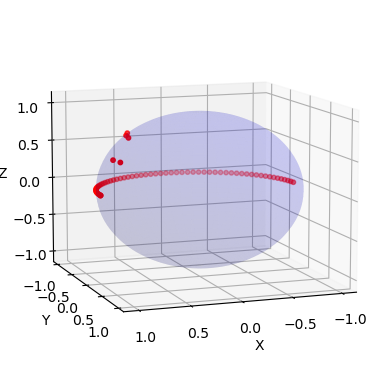

In [10]:
#plot original projections
rotation_angles_rad = dc.geometry.inner_angles[:]
tilt_angles_rad = list(np.pi/2-np.array(dc.geometry.outer_angles))[:]

r = 1
x = r * np.sin(tilt_angles_rad) * np.cos(rotation_angles_rad)
y = r * np.sin(tilt_angles_rad) * np.sin(rotation_angles_rad)
z = r * np.cos(tilt_angles_rad)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
X = r * np.outer(np.cos(u), np.sin(v))
Y = r * np.outer(np.sin(u), np.sin(v))
Z = r * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(X, Y, Z, color='b', alpha=0.1)  
ax.scatter(x, y, z, color='r', s=10)  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=10, azim=70)
plt.show()

In [11]:
#projections used for reconstruction
projections

Field,Size,Data
data,"(63, 73, 100, 8)",ee0af6 (hash)
diode,"(63, 73, 100)",48addf (hash)
weights,"(63, 73, 100, 8)",c13cc8 (hash)
Number of pixels j,1,73
Number of pixels k,1,100


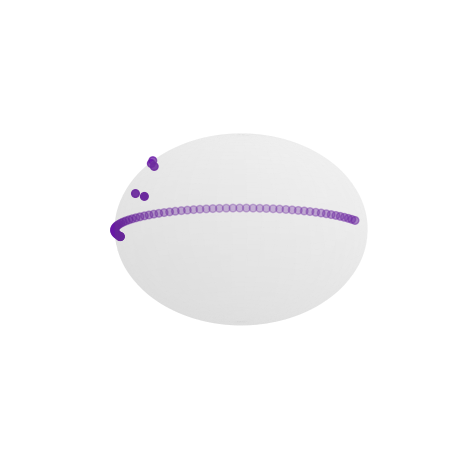

In [12]:
#plot the remaining projections 
rotation_angles_rad = dc.geometry.inner_angles[:]
tilt_angles_rad = list(np.pi/2 - np.array(dc.geometry.outer_angles))[:]

r = 1
x = r * np.sin(tilt_angles_rad) * np.cos(rotation_angles_rad)
y = r * np.sin(tilt_angles_rad) * np.sin(rotation_angles_rad)
z = r * np.cos(tilt_angles_rad)
color_values = np.arange(len(x))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
X = r * np.outer(np.cos(u), np.sin(v))
Y = r * np.outer(np.sin(u), np.sin(v))
Z = r * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(X, Y, Z, color='lightgray', alpha=0.1)
sc = ax.scatter(x, y, z, color='#6817a6', s=30)  
ax.set_axis_off()
ax.grid(False)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.view_init(elev=10, azim=70)
plt.tight_layout()
plt.show()

# mumott reconstruction

In [13]:
import h5py
from IPython.display import display
# from ipywidgets import interact
from mumott.data_handling import DataContainer
from mumott.output_handling import ProjectionViewer
from mumott.output_handling.saving import dict_to_h5
from mumott.methods.basis_sets import SphericalHarmonics, GaussianKernels
from mumott.methods.projectors import SAXSProjectorCUDA as SAXSProjector
from mumott.methods.residual_calculators import GradientResidualCalculator
from mumott.optimization.loss_functions import SquaredLoss
from mumott.optimization.optimizers import LBFGS
from mumott.optimization.regularizers import Laplacian

In [14]:
import torch
basis_set = SphericalHarmonics(ell_max=8)
projector = SAXSProjector(dc.geometry)
ResidualCalculator = GradientResidualCalculator(
                                data_container=dc,
                                basis_set=basis_set,
                                projector=projector)
loss_function = SquaredLoss(ResidualCalculator)
regularizer = Laplacian()
loss_function.add_regularizer(name='laplacian',
                              regularizer=regularizer,
                              regularization_weight=1)
optimizer = LBFGS(loss_function, maxiter=10)

In [15]:
basis_set.ell_indices, basis_set.emm_indices

(array([0, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8]),
 array([ 0, -2, -1,  0,  1,  2, -4, -3, -2, -1,  0,  1,  2,  3,  4, -6, -5,
        -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6, -8, -7, -6, -5, -4, -3,
        -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8]))

In [17]:
results = optimizer.optimize()

 80%|████████  | 8/10 [00:50<00:12,  6.35s/it]


In [18]:
# # Save reconstruction as video
# import matplotlib.animation as animation
# from matplotlib.animation import FFMpegWriter

# # Create figure and axis
# fig, ax = plt.subplots(figsize=(10, 8))

# # Get the data dimensions
# data = reconstruction[:, :, :, 2]
# num_slices = data.shape[2]

# # Initialize the image
# im = ax.imshow(data[:, :, 0], cmap='gray', vmin=data.min(), vmax=data.max())
# ax.set_title(f'Reconstruction Slice 0/{num_slices-1}')
# ax.axis('off')

# def animate(frame):
#     im.set_array(data[:, :, frame])
#     ax.set_title(f'Reconstruction Slice {frame}/{num_slices-1}')
#     return [im]

# # Create animation
# anim = animation.FuncAnimation(fig, animate, frames=num_slices, interval=200, blit=True, repeat=True)

# # Save as video
# writer = FFMpegWriter(fps=5, metadata=dict(artist='Me'), bitrate=1800)
# anim.save('/Users/lfbarba/GitHub/smartTT/reconstruction_video.mp4', writer=writer)

# print(f"Video saved as reconstruction_video.mp4 with {num_slices} frames")
# plt.show()

In [19]:
# new geometry
reduced_geometry = dc.geometry

In [20]:
sorted_indices_to_keep = sorted(indices_to_keep)
sorted_indices_to_predict = sorted(indices_to_predict)

In [21]:
inner_angles = np.loadtxt('bone_in_ang.txt')
outer_angles = np.loadtxt('bone_out_ang.txt')

In [22]:
# sort the indices
inner_angles_new_list = np.array(inner_angles.tolist())[sorted_indices_to_predict].tolist()
outer_angles_new_list = np.array(outer_angles.tolist())[sorted_indices_to_predict].tolist()
rotations_real_new_list = np.array(rotations_real)[sorted_indices_to_predict].tolist()
joff_new_list = np.array(joff)[sorted_indices_to_predict].tolist()
koff_new_list = np.array(koff)[sorted_indices_to_predict].tolist()

# forward propagation

In [23]:
# build a new 'geometry', refer to https://mumott.org/tutorials/simulating_samples.html
from mumott.core.geometry import GeometryTuple
geometry = Geometry()

number_of_projections = n

for i in range(number_of_projections):
    geometry.append(GeometryTuple())

geometry.inner_angles = inner_angles_new_list
geometry.outer_angles = outer_angles_new_list
geometry.p_direction_0 = np.array([0, 0, 1])
geometry.j_direction_0 = np.array([0, 1, 0])
geometry.k_direction_0 = np.array([1, 0, 0])
geometry.inner_axes = np.array([-1, 0, 0])
geometry.outer_axes = np.array([0, -1, 0])
geometry.detector_direction_positive_90 = np.array([0, 1, 0])
geometry.j_offsets = joff_new_list
geometry.k_offsets = koff_new_list

geometry.volume_shape = reconstruction.shape[0:3]
geometry.detector_angles = np.loadtxt('detector_angles.txt')
geometry.projection_shape = np.array((65, 55))
geometry.write('bone_user_geometry.geo')

INFO:None values found in some axis or angle entries, rotations not updated.
INFO:None values found in some axis or angle entries, rotations not updated.
INFO:None values found in some axis or angle entries, rotations not updated.


IndexError: list index out of range

In [24]:
geometry

Field,Size,Data
rotations,5,92fce1 (hash)
j_offsets,5,feb6ab (hash)
k_offsets,5,feb6ab (hash)
p_direction_0,3,[0. 0. 1.]
j_direction_0,3,[0. 1. 0.]
k_direction_0,3,[1. 0. 0.]
inner_angles,0,786a02 (hash)
outer_angles,0,786a02 (hash)
inner_axes,5,18e9dc (hash)
outer_axes,5,c2dcf0 (hash)


In [25]:
projector = SAXSProjectorCUDA(geometry) if torch.cuda.is_available() else SAXSProjector(dc.geometry)
basis_set = SphericalHarmonics(ell_max=8, probed_coordinates=geometry.probed_coordinates) 
forward_projections = basis_set.forward(projector.forward(reconstruction.astype(np.float64)))

IndexError: index -1 is out of bounds for axis 0 with size 0

In [26]:
forward_projections.shape

NameError: name 'forward_projections' is not defined